In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
from random import randint
import os
import tensorflow as tf
from PIL import Image
from sklearn.metrics import confusion_matrix
import skimage

Dataset location specification

In [0]:
DATASET_DIR = os.path.join('/content', 'drive', 'My Drive', 'Colab Notebooks', 'HW2', 'data')

training_file = os.path.join(DATASET_DIR, 'train.p')
validation_file = os.path.join(DATASET_DIR, 'valid.p')
testing_file = os.path.join(DATASET_DIR, 'test.p')

Load dataset

In [0]:
with open(training_file, 'rb') as f:
    train = pickle.load(f)
with open(validation_file, 'rb') as f:
    valid = pickle.load(f)
with open(testing_file, 'rb') as f:
    test = pickle.load(f)

x_train, y_train = train['features'], train['labels']
x_validation, y_validation = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

Summary of Dataset

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)
43


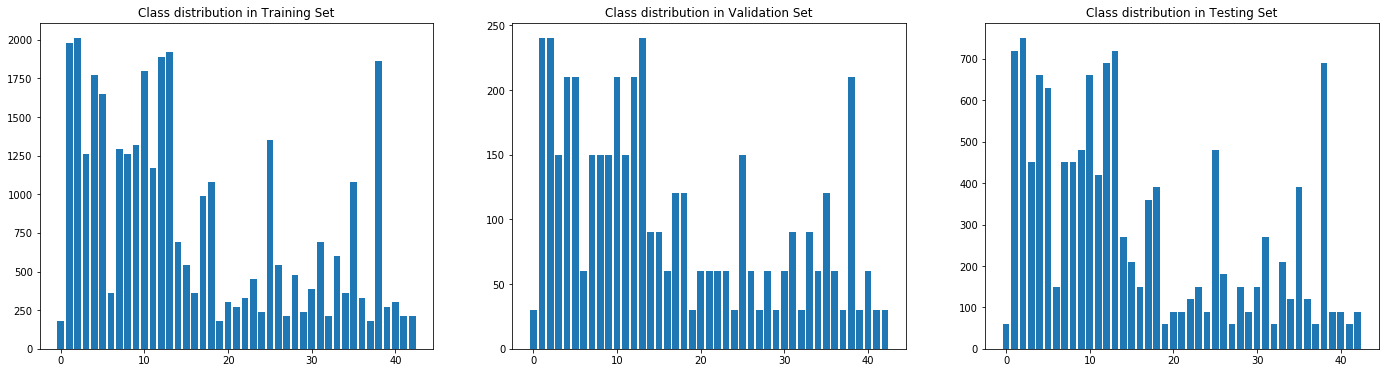

In [36]:
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)
print(x_test.shape, y_test.shape)

ListOfClass = list(set(y_train))
NumOfClass = len(ListOfClass)
print(NumOfClass)

Label = [
    'Speed limit (20km/h)',
    'Speed limit (30km/h)',
    'Speed limit (50km/h)',
    'Speed limit (60km/h)',
    'Speed limit (70km/h)',
    'Speed limit (80km/h)',
    'End of speed limit (80km/h)',
    'Speed limit (100km/h)',
    'Speed limit (120km/h)',
    'No passing',
    'No passing for vehicles over 3.5 metric tons',
    'Right-of-way at the next intersection',
    'Priority road',
    'Yield',
    'Stop',
    'No vehicles',
    'Vehicles over 3.5 metric tons prohibited',
    'No entry',
    'General caution',
    'Dangerous curve to the left',
    'Dangerous curve to the right',
    'Double curve',
    'Bumpy road',
    'Slippery road',
    'Road narrows on the right',
    'Road work',
    'Traffic signals',
    'Pedestrians',
    'Children crossing',
    'Bicycles crossing',
    'Beware of ice/snow',
    'Wild animals crossing',
    'End of all speed and passing limits',
    'Turn right ahead',
    'Turn left ahead',
    'Ahead only',
    'Go straight or right',
    'Go straight or left',
    'Keep right',
    'Keep left',
    'Roundabout mandatory',
    'End of no passing',
    'End of no passing by vehicles over 3.5 metric tons',
]

training_stat = np.zeros(NumOfClass, dtype=int)
validation_stat = np.zeros(NumOfClass, dtype=int)
testing_stat = np.zeros(NumOfClass, dtype=int)

for e in y_train:
  training_stat[e] += 1
for e in y_validation:
  validation_stat[e] += 1
for e in y_test:
  testing_stat[e] += 1

plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1)
plt.bar(range(NumOfClass), training_stat)
plt.title('Class distribution in Training Set')
plt.subplot(1, 3, 2)
plt.bar(range(NumOfClass), validation_stat)
plt.title('Class distribution in Validation Set')
plt.subplot(1, 3, 3)
plt.bar(range(NumOfClass), testing_stat)
plt.title('Class distribution in Testing Set')
plt.show()

Exploration and Visualization

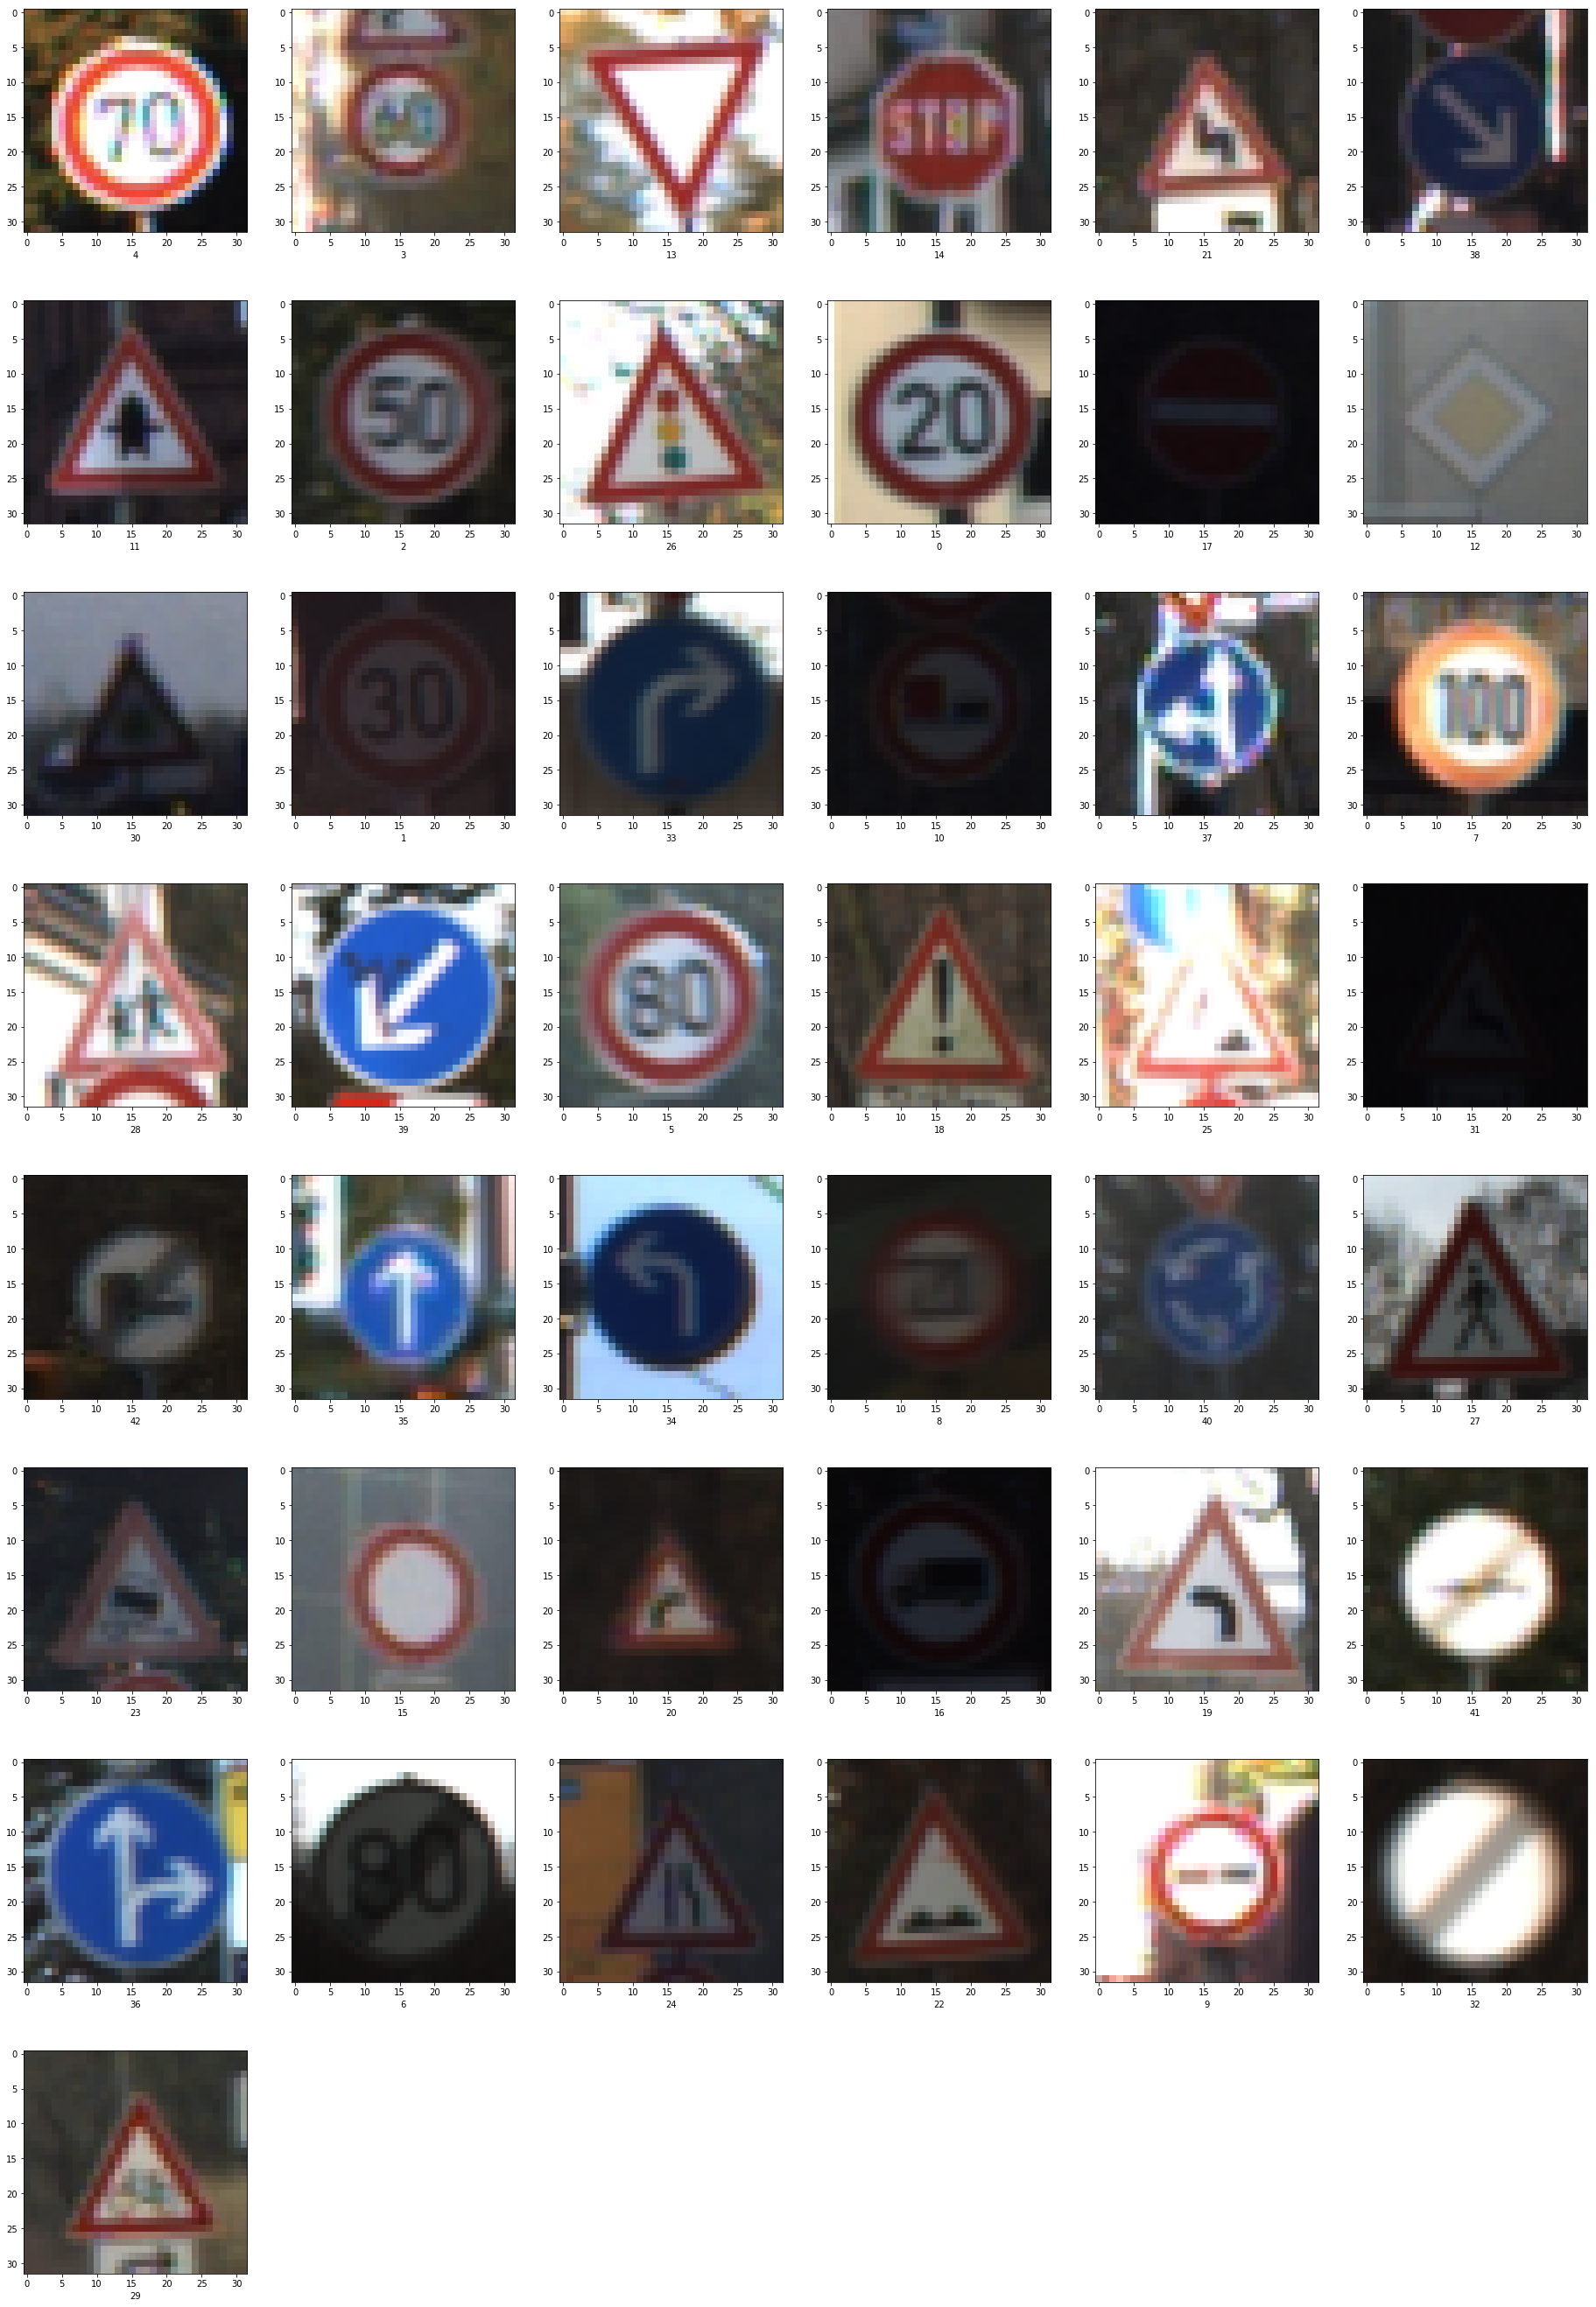

In [37]:
flag = np.zeros(NumOfClass, dtype=int)
cnt = NumOfClass
plt.figure(figsize=(32, 48))
while cnt > 0:
    idx = randint(1, len(y_train))-1
    label = y_train[idx]
    if flag[label] == 0:
        flag[label] = 1
        cnt -= 1
        plt.subplot(8, 6, NumOfClass-cnt)
        plt.imshow(x_train[idx])
        plt.xlabel(str(label))
plt.savefig('explore.png', dpi=300)
plt.show()

Process the dataset

In [0]:
def hist_eq_v(img):
  hsv_img = skimage.color.rgb2hsv(img)
  
  v_channel = hsv_img[:, :, 2]
  v_min = np.min(v_channel)
  v_max = np.max(v_channel)
  
  if v_max - v_min < 128:
    hsv_img[:, :, 2] = skimage.exposure.equalize_hist(hsv_img[:, :, 2])
    new_img = skimage.color.hsv2rgb(hsv_img)
    return new_img
  else:
    return img

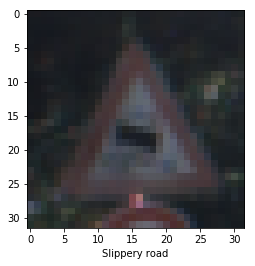

In [39]:
# Image before processing
plt.imshow(x_train[2002])
plt.xlabel(Label[y_train[2002]])
plt.show()

In [40]:
x_train = np.array([hist_eq_v(img) for img in x_train])
print(x_train.shape)
x_validation = np.array([hist_eq_v(img) for img in x_validation])
print(x_validation.shape)
x_test = np.array([hist_eq_v(img) for img in x_test])
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


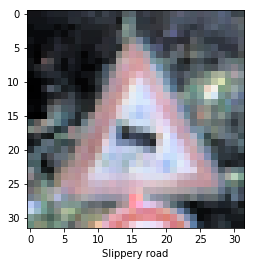

In [41]:
# Image after processing
plt.imshow(x_train[2002])
plt.xlabel(Label[y_train[2002]])
plt.show()

Building model...

In [52]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(NumOfClass, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 128)       36992     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 6, 6, 128)        

Compiling model...

In [0]:
loc_optimizer = tf.keras.optimizers.Adam(lr=1e-3, )
loc_loss = tf.keras.losses.sparse_categorical_crossentropy
loc_metrics = ['accuracy']
model.compile(optimizer=loc_optimizer,loss=loc_loss,metrics=loc_metrics)

Fitting model...

In [55]:
r0 = model.fit(x_train.astype(np.float32), y_train.astype(np.float32), validation_data=(x_validation, y_validation), verbose = 1, batch_size = 128, epochs=12)

Train on 34799 samples, validate on 4410 samples
Epoch 1/12
34799/34799 [==============================] - 6s 176us/sample - loss: 1.6985 - acc: 0.5463 - val_loss: 5.4309 - val_acc: 0.0476
Epoch 2/12
34799/34799 [==============================] - 6s 162us/sample - loss: 0.3491 - acc: 0.8939 - val_loss: 1.2170 - val_acc: 0.6215
Epoch 3/12
34799/34799 [==============================] - 6s 162us/sample - loss: 0.1681 - acc: 0.9474 - val_loss: 0.1219 - val_acc: 0.9651
Epoch 4/12
34799/34799 [==============================] - 6s 162us/sample - loss: 0.1129 - acc: 0.9639 - val_loss: 0.0672 - val_acc: 0.9776
Epoch 5/12
34799/34799 [==============================] - 6s 160us/sample - loss: 0.0868 - acc: 0.9724 - val_loss: 0.0505 - val_acc: 0.9834
Epoch 6/12
34799/34799 [==============================] - 6s 160us/sample - loss: 0.0619 - acc: 0.9801 - val_loss: 0.0779 - val_acc: 0.9741
Epoch 7/12
34799/34799 [==============================] - 6s 159us/sample - loss: 0.0648 - acc: 0.9793 - val_lo

History of training

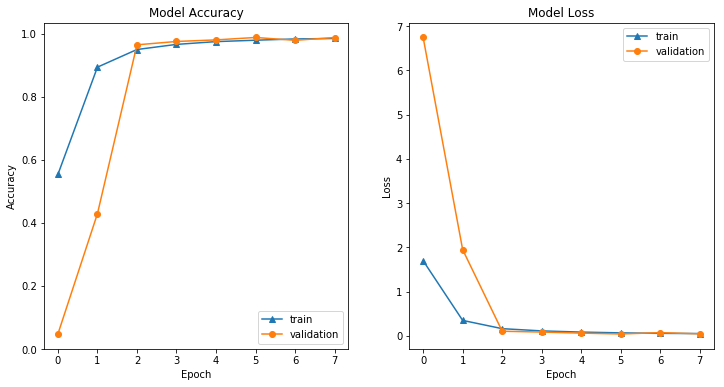

In [45]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(r0.history['acc'], '-^')
plt.plot(r0.history['val_acc'], '-o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(r0.history['loss'], '-^')
plt.plot(r0.history['val_loss'], '-o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Evaluating model...

In [46]:
r1 = model.evaluate(x_test.astype(np.float32), y_test.astype(np.float32), verbose = 1)
print("Loss: ", r1[0])
print("Accuracy: ", r1[1])

12630/12630 [==============================] - 1s 102us/sample - loss: 0.0850 - acc: 0.9755
Loss:  0.08495940143368617
Accuracy:  0.97553444


Analyse testing accuracy

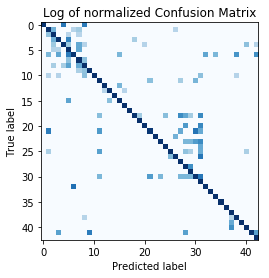

In [47]:
pred_test = model.predict_classes(x_test)
cm = confusion_matrix(y_test, pred_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Predicting on 10 figures randomly choosen from testing dataset ...

   Index                                                      Prediction                                                          Actual   Judgement
    9741                    No passing for vehicles over 3.5 metric tons                    No passing for vehicles over 3.5 metric tons           1
    4984                                            Speed limit (50km/h)                                            Speed limit (50km/h)           1
    3174                                                      Ahead only                                                      Ahead only           1
    5554                           Right-of-way at the next intersection                           Right-of-way at the next intersection           1
    1244                                                   Priority road                                                   Priority road           1
    1170                           Right-of-way at the next intersection                           Right-o

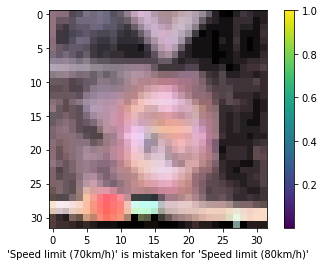

In [48]:
idx = []
cnt = 0
while cnt < 10:
  loc_idx = randint(0, 12630)
  if loc_idx not in idx:
    idx.append(loc_idx)
    cnt = cnt + 1

pred = model.predict_classes(np.array([x_test[e] for e in idx]))
judgement = []

print("{:>8s}{:>64s}{:>64s}{:>12s}".format("Index", "Prediction", "Actual", "Judgement"))
for i in range(10):
  loc_idx = idx[i]
  loc_pred = pred[i]
  loc_ans = y_test[idx[i]]
  loc_judge = pred[i]== y_test[idx[i]]
  judgement.append(loc_judge)
  print("{:>8d}{:>64s}{:>64s}{:>12b}".format(loc_idx, Label[loc_pred], Label[loc_ans], loc_judge))
  
for i in range(10):
  if not judgement[i]:
    loc_idx = idx[i]
    plt.figure()
    loc_img = np.squeeze(x_test[loc_idx])
    plt.imshow(loc_img)
    plt.colorbar()
    plt.grid(False)
    plt.xlabel("\'{:s}\' is mistaken for \'{:s}\'".format(Label[y_test[loc_idx]], Label[pred[i]]))
    plt.show()

Load images downloaded from Internet and adjust size


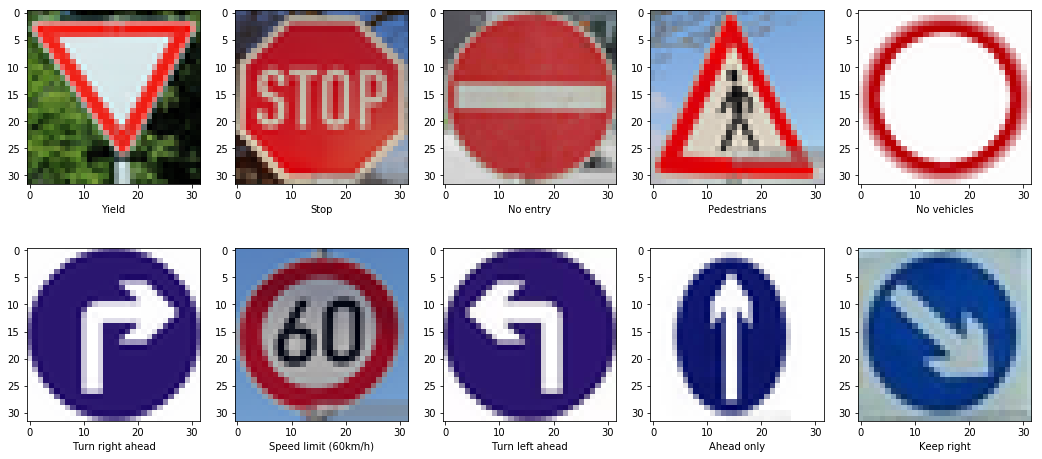

(10, 32, 32, 3)


In [49]:
DOWNLOAD_DIR = os.path.join('/content', 'drive', 'My Drive', 'Colab Notebooks', 'HW2', 'download')
x_download = []
y_download = np.zeros(10, dtype='int')
plt.figure(figsize=(18, 8))
cnt = 0
for e in os.listdir(DOWNLOAD_DIR):
  label, ext = e.split('.')
  cur_path = os.path.join(DOWNLOAD_DIR, e)
  cur_img = Image.open(cur_path)
  adj_img = cur_img.resize((32, 32), Image.ANTIALIAS)
  x_download.append(np.array(adj_img))
  y_download[cnt] = int(label)
  plt.subplot(2, 5, cnt+1)
  plt.imshow(x_download[cnt])
  plt.xlabel(Label[y_download[cnt]])
  cnt += 1

plt.show()
x_download = np.array(x_download)
print(x_download.shape)

Predict on downloaded images

   Index                                                      Prediction                                                          Actual   Judgement
       0                                                           Yield                                                           Yield           1
       1                                                            Stop                                                            Stop           1
       2                                                        No entry                                                        No entry           1
       3                                                     Pedestrians                                                     Pedestrians           1
       4                                                     No vehicles                                                     No vehicles           1
       5                                                Turn right ahead                                  

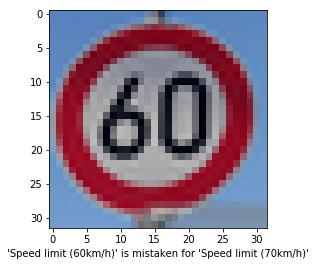

In [50]:
download_pred = model.predict_classes(x_download)
download_judge = download_pred == y_download

print("{:>8s}{:>64s}{:>64s}{:>12s}".format("Index", "Prediction", "Actual", "Judgement"))
for i in range(10):
  loc_pred = download_pred[i]
  loc_ans = y_download[i]
  print("{:>8d}{:>64s}{:>64s}{:>12b}".format(i, Label[loc_pred], Label[loc_ans], download_judge[i]))
  
for i in range(10):
  if not download_judge[i]:
    plt.imshow(x_download[i])
    plt.xlabel("\'{:s}\' is mistaken for \'{:s}\'".format(Label[y_download[i]], Label[download_pred[i]]))
    plt.show()


Top 5 softmax probabilities

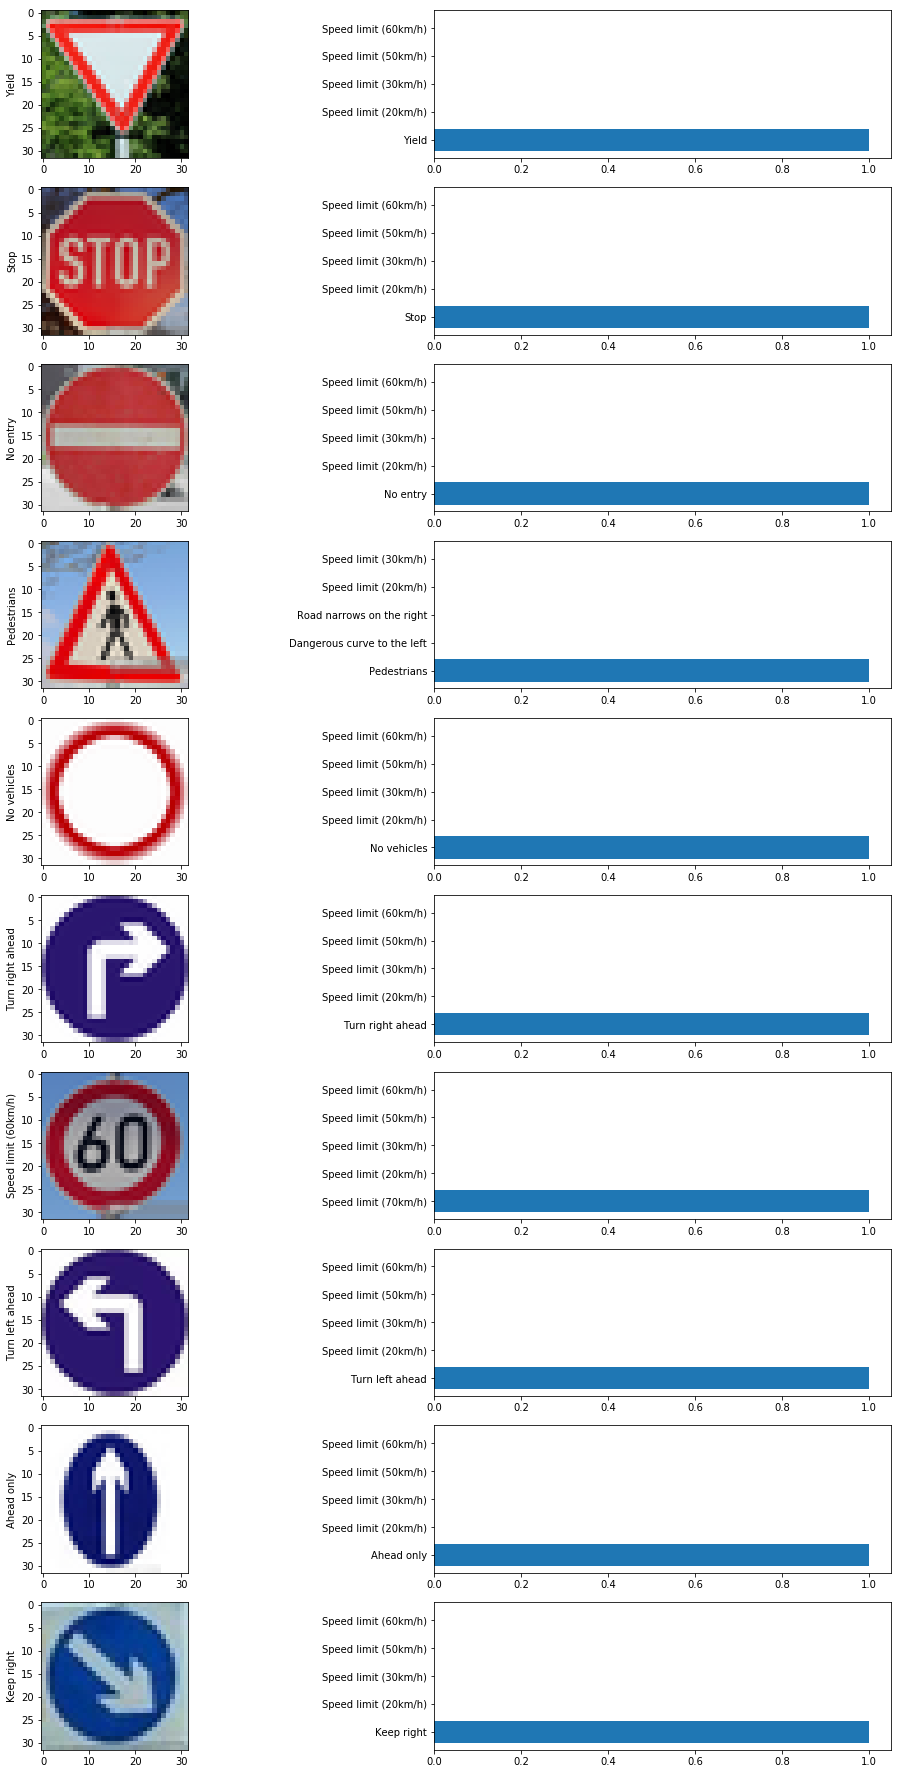

In [51]:
pred_download = model.predict(x_download)

plt.figure(figsize=(18, 32))
for i in range(10):
  plt.subplot(10, 2, 2*i+1)
  plt.imshow(x_download[i])
  plt.ylabel(Label[y_download[i]])
  plt.grid(False)
  
  plt.subplot(10, 2, 2*i+2)
  stat = list(zip(pred_download[i], Label))
  stat.sort(key=lambda e: e[0], reverse=True)
  
  plt.barh(np.arange(1, 6, 1), [stat[j][0] for j in range(5)])
  plt.yticks(np.arange(1, 6, 1), [stat[j][1] for j in range(5)])
  
plt.show()
